In [314]:
import random
import matplotlib.pyplot as plt
import numpy as np
try:
    from docplex.mp.model import Model
except:
    raise Exception('Installez docplex !pip install docplex')
from scipy.spatial import distance

Définition des paramètres

In [315]:
capacité = 50 # capacité de la camionnette du marchand de poisson
nclients = 15 # nombre de clients 
nmagasins = 3 # nombre d'emplacements possibles pour les dépôts
lbdemande = 5 # borne inférieure pour la quantité demandée par les clients
ubdemande = 25 # borne supérieure pour la quantité demandée par les clients

Génération des données aléatoires

In [316]:
# fixer le seed du random pour toujours avoir les mêmes données 
random.seed(17)
# numéro des clients  
N = [int(i) for i in range(nmagasins, nclients+nmagasins)]
# graphe V qui reprend les noeuds des emplacements + les noeuds des clients 
V = [i for i in range(nmagasins)] + N 
# génération aléatoire des quantités pour chaque client / dictionnaire : clé = numéro client, valeur = quantitié demandée 
demandes = {i:random.randint(lbdemande,ubdemande) for i in N}
# génération des coordonnées aléatoires des clients  
clients = [(random.randint(0,30),random.randint(0,30)) for _ in range(nclients)]
# génération des coordonnées aléatoires des magasins 
magasins = [(random.randint(0,30), random.randint(0,30)) for _ in range(nmagasins)] 

Affichage des clients avec la quantité demandée et des emplacements possibles des dépôts

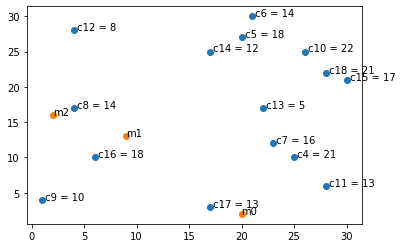

In [317]:
fig, ax = plt.subplots()
# clients axe x et axe y
xclients, yclients = [client[0] for client in clients], [client[1] for client in clients]
# magasin axe x et axe y
xmagasins, ymagasins = [magasin[0] for magasin in magasins], [magasin[1] for magasin in magasins]
ax.scatter(xclients, yclients) 
ax.scatter(xmagasins, ymagasins)
for i, q in enumerate(demandes.values()):
    ax.annotate(f' c{i+nmagasins+1} = {q}', (xclients[i],yclients[i]))
for i in range(nmagasins):
    ax.annotate(f'm{i}', (xmagasins[i],ymagasins[i]))
plt.show()

Définition du modèle

In [318]:
def ModelInit(arcs, capacité, demandes, distances, N, nmagasins):
    model = Model('CVRP')
    x = model.binary_var_dict(arcs, name = 'x') # variable binaire pour les arcs -> 0 ou 1 en fonction de si on le prend ou pas
    u = model.continuous_var_dict(N, ub = capacité, name = 'u') # ub = upperbound = capacité camionnette
    model.minimize(model.sum(distances[i,j]*x[i,j] for i,j in arcs)) # fct objectif = minimiser la distance entre les arcs qui sont pris
    model.add_constraints(model.sum(x[i,j] for j in V if j!=i) == 1 for i in N) # graphe connexe, tous les arcs doivent être liés
    model.add_constraints(model.sum(x[i,j] for i in V if i!=j) == 1 for j in N)
    model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i]+demandes[j] == u[j]) for i, j in arcs if (i not in range(nmagasins) and j not in range(nmagasins)))
    model.add_constraints(u[i] >= demandes[i] for i in N)
    # model.parameters.timelimit = 60
    return model
  

In [319]:
def solver(model):
    return model.solve(log_output = False)

In [320]:
from docplex.mp.progress import ProgressListener, ProgressClock
from IPython import display
from docplex.mp.progress import *

class MipGapPlotter(ProgressListener):
    
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.Objective)
        plt.ion()
        self.fig, self.axs = plt.subplots(1,2, figsize = (20,8))
    def notify_start(self):
        self.gaps = []
        self.times = []
        self.objectives = []
        self.iterations = []
        self.noeuds = []
        self.remaining_noeuds = []
        self.axs[0].set_title('Evolution fct obj')
        self.axs[1].set_title('Evolution gap')
        self.axs[0].set_ylabel('Fonction objectif')
        self.axs[0].set_xlabel('Temps (ms)')
        self.axs[1].set_ylabel('Gap (%)')
        self.axs[1].set_xlabel('Temps (ms')
        
    def notify_progress(self, pdata):
        objective = pdata.current_objective
        iteration = pdata.current_nb_iterations
        noeud = pdata.current_nb_nodes
        gap = pdata.mip_gap
        remaining_noeud = pdata.remaining_nb_nodes
        time = pdata.time
        self.gaps.append(gap*100) #gap
        self.times.append(1000* time) # temps 
        self.objectives.append(objective) # fct obj
        self.iterations.append(iteration) # n itérations 
        self.noeuds.append(noeud) # nombre de noeuds actuels 
        self.remaining_noeuds.append(remaining_noeud) # nombre de noeuds restants
        self.axs[0].plot(self.times, self.objectives, 'go-')
        self.axs[1].plot(self.times, self.gaps)
        display.display(plt.gcf())
        display.clear_output(wait=True)

Définition des arcs d'un noeud i à un noeud j et calcul de distance pour chaque arc

La plus petite distance à parcourir est 197.93973148232624


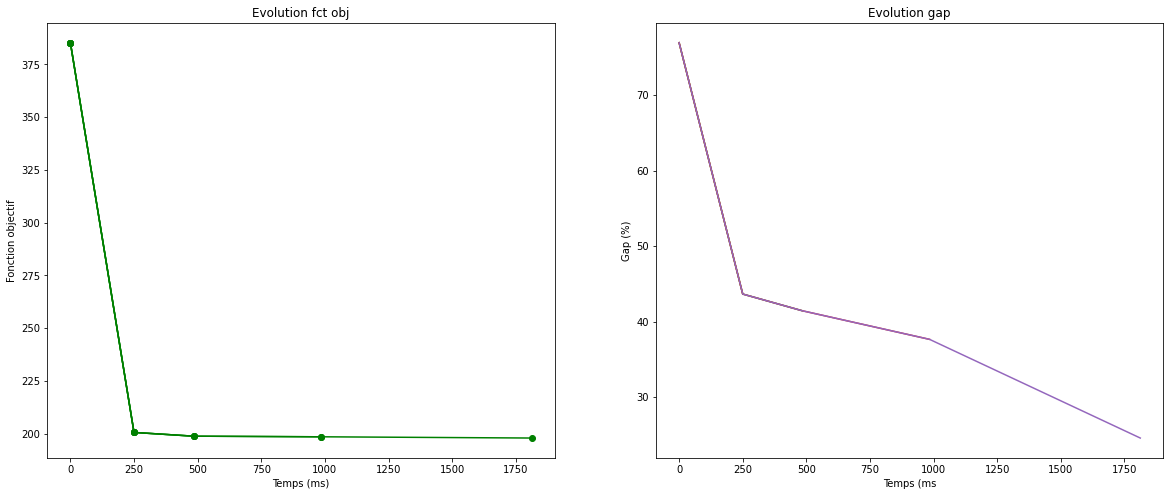

In [321]:
best_value = 10**10
best_magasin = None
best_solution = None

# coordonnées x et y des clients et magasins 
xtot, ytot = xmagasins + xclients, ymagasins + yclients

# initialisation des arcs du graphe -> on veut éviter d'avoir un arc d'un noeud vers lui même (i != j) et d'un dépôt vers un autre dépôt
arcs = [(i,j) for i in V for j in V if (i not in range(nmagasins) or j not in range(nmagasins) and i != j)]

# calcul des distances entre les clients et les magasins -> pour chaque arc, on obtient une distance euclidienne
dists = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}

# distance de City Block (Manhattan)
cityblockdist = {(i,j): distance.cityblock([xtot[i], xtot[j]], [ytot[i], ytot[j]]) for i,j in arcs}


def display_recorded_solutions(rec):
    print('* The recorder contains {} solutions'.format(rec.number_of_solutions))
    for s, sol in enumerate(rec.iter_solutions(), start=1):
        sumvals = sum(v for _, v in sol.iter_var_values())
        print('  - solution #{0}, obj={1}, non-zero-values={2}, total={3}'.format(
           s, sol.objective_value, sol.number_of_var_values, sumvals))
        

model = ModelInit(arcs, capacité, demandes, dists, N, nmagasins)
sol_recorder = SolutionRecorder(clock='objective')
model.clear_progress_listeners()
model.add_progress_listener(sol_recorder)
model.solve(clean_before_solve=True)
display_recorded_solutions(sol_recorder)
solution = solver(model)
model.add_progress_listener(MipGapPlotter())
model.solve(clean_before_solve=True);

value = solution.objective_value
print(f'La plus petite distance à parcourir est {value}')

In [322]:
"""best_value = 10**10
best_magasin = None
best_solution = None
for magasin in range(nmagasins):
    xtot, ytot = xmagasins[magasin] + xclients, ymagasins[magasin] + yclients
    arcs = [(i,j) for i in V for j in V if (i not in range(nmagasins) or j not in range(nmagasins) and i != j)]
    dists = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}
    model = ModelInit(arcs, capacité, demandes, dists, N)
    solution = solver(model)
    value = solution.objective_value
    if value < best_value:
        best_value = value 
        best_magasin = magasin
        best_solution = solution
print(f'La plus petite distance à parcourir est {best_value}')
print(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')"""

"best_value = 10**10\nbest_magasin = None\nbest_solution = None\nfor magasin in range(nmagasins):\n    xtot, ytot = xmagasins[magasin] + xclients, ymagasins[magasin] + yclients\n    arcs = [(i,j) for i in V for j in V if (i not in range(nmagasins) or j not in range(nmagasins) and i != j)]\n    dists = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}\n    model = ModelInit(arcs, capacité, demandes, dists, N)\n    solution = solver(model)\n    value = solution.objective_value\n    if value < best_value:\n        best_value = value \n        best_magasin = magasin\n        best_solution = solution\nprint(f'La plus petite distance à parcourir est {best_value}')\nprint(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')"

In [323]:
# identification des arcs actifs pour l'affichage
arcs_actifs = []
for val in (model.iter_binary_vars()):
    if val.solution_value > 0.95:
        v = val.name.split('_')
        arcs_actifs.append((int(v[1]), int(v[2])))

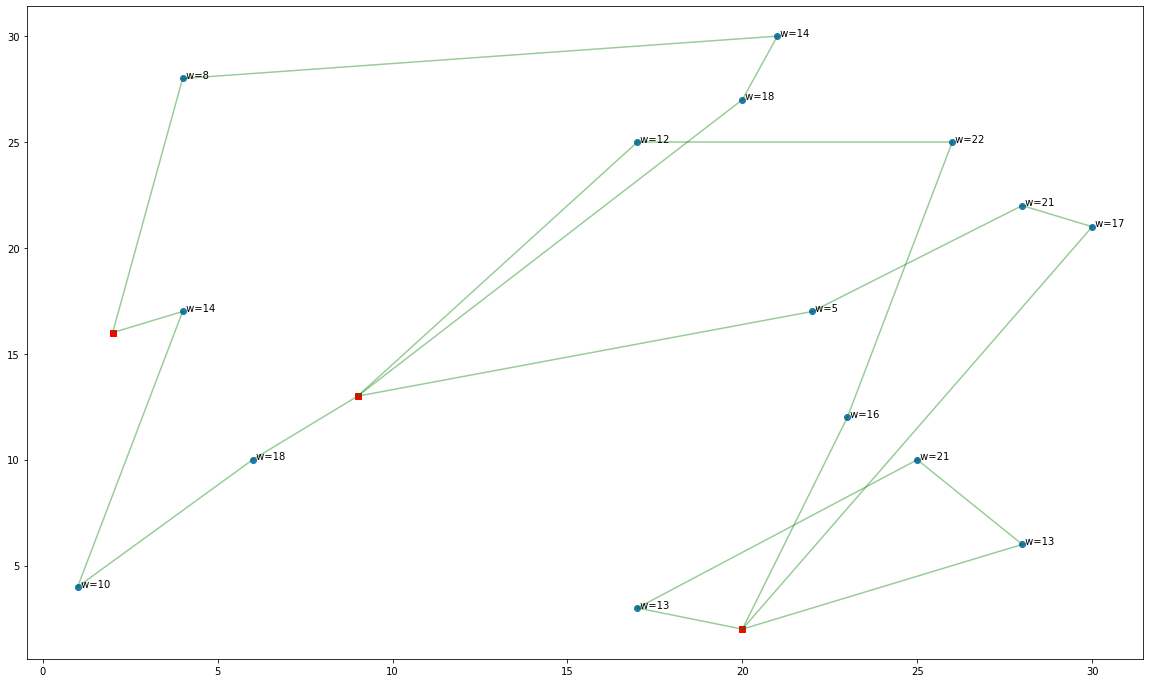

In [324]:
fig, ax = plt.subplots(figsize = (20,12)) 
# affichage des clients 
ax.scatter(xclients, yclients) 
for i in N:
    plt.annotate(f' w={demandes[i]}', (xtot[i], ytot[i]))

# affichage des magasins 
for i in range(nmagasins):
    plt.plot(xmagasins[i],ymagasins[i], c='r', marker='s') # affichage des magasins


# affichage des arcs actifs
for i,j in arcs_actifs:
    plt.plot([xtot[i], xtot[j]], [ytot[i], ytot[j]], c='g', alpha=0.4)
plt.show()

A faire

- tester avec differents types de distances
- tester avec differents parametres
- benchmark temps et distance en fonction du nb d'emplacement etc
- graphe résultats



